# Time series forecasting

# Initial setup

## Import required packages

In [101]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Import time series data: Airline passenger traffic

In [104]:
data = pd.read_csv('UNRATE.csv' ,header=None)
data.columns = ['Month','Passengers']
# data['Month'] = pd.to_datetime(data['Month'], format='%d-%m-%Y')
data['Month'] = pd.to_datetime(data['Month'], format='%d-%m-%Y')
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6
1948-07-01,3.6
1948-08-01,3.9
1948-09-01,3.8


# Time series analysis

## Plot time series data

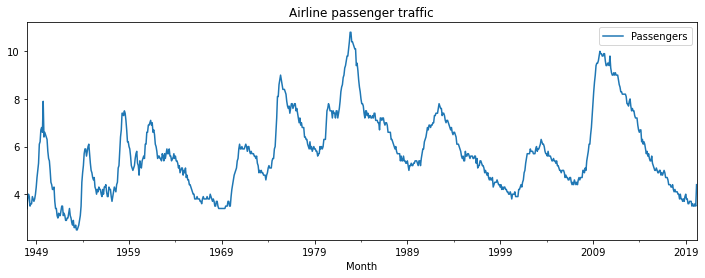

In [105]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

## Missing value treatment

### Mean imputation

In [106]:
# data = data.assign(Passengers_Mean_Imputation=data.Passengers.fillna(data.Passengers.mean()))
# data[['Passengers_Mean_Imputation']].plot(figsize=(12, 4))
# plt.legend(loc='best')
# plt.title('Airline passenger traffic: Mean imputation')
# plt.show(block=False)

### Linear interpolation

In [107]:
# data = data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
# data[['Passengers_Linear_Interpolation']].plot(figsize=(12, 4))
# plt.legend(loc='best')
# plt.title('Airline passenger traffic: Linear interpolation')
# plt.show(block=False)

### Use linear interpolation to impute missing values

In [108]:
# data['Passengers'] = data['Passengers_Linear_Interpolation']
# data.drop(columns=['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],inplace=True)

## Split time series data into training and test set

In [109]:
train_len = 612
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

# Auto Regressive methods

## Stationarity vs non-stationary time series

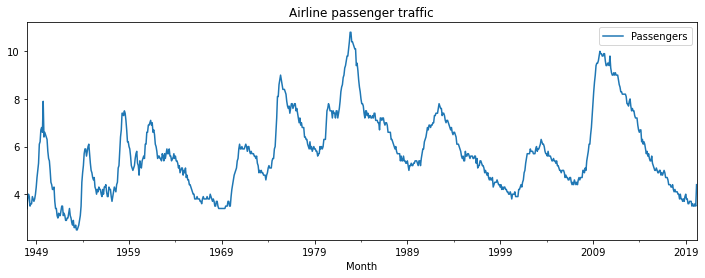

In [110]:
data['Passengers'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

### Box Cox transformation to make variance constant

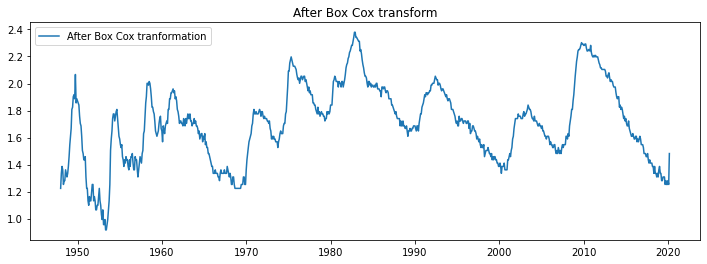

In [111]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

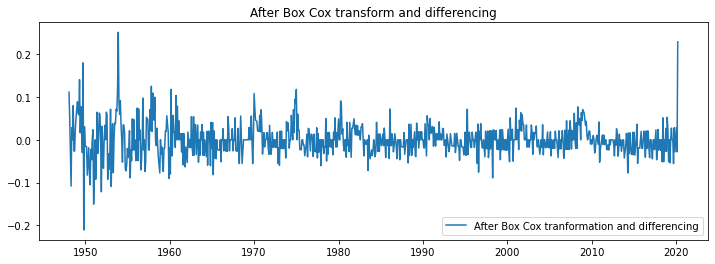

In [112]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [113]:
data_boxcox_diff.dropna(inplace=True)

In [114]:
data_boxcox_diff.tail()

Month
2019-11-01   -0.028171
2019-12-01    0.000000
2020-01-01    0.028171
2020-02-01   -0.028171
2020-03-01    0.228842
dtype: float64

In [115]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

## Auto regression method (AR)

In [116]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090455
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047124
ar.L12.y   -0.148533
dtype: float64


### Recover original time series

In [117]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot train, test and forecast

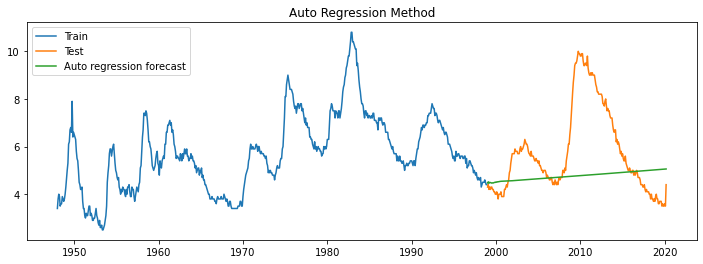

In [118]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [119]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ar['ar_forecast'][test.index.min():])/test['Passengers'])*100,2)

In [120]:
print(rmse, mape)

2.07 21.5


## Moving average method (MA)

In [50]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.009538
ma.L1.y    0.266103
dtype: float64


C:\Users\25003850\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Recover original time series

In [51]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

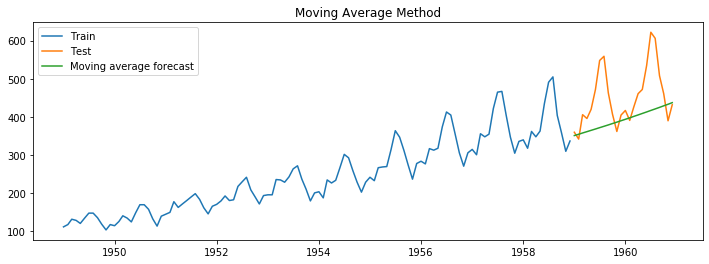

In [52]:
plt.figure(figsize=(12,4))
plt.plot(data['Passengers'][:train_len], label='Train')
plt.plot(data['Passengers'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [53]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ma['ma_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.10,6.53
0,Holt Winters' multiplicative method,34.83,6.91
0,Autoregressive (AR) method,93.39,13.77
0,Moving Average (MA) method,91.21,13.39


## Auto regression moving average method (ARMA)

In [54]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.009624
ar.L1.y   -0.527115
ma.L1.y    0.798281
dtype: float64


C:\Users\25003850\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Recover original time series

In [55]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

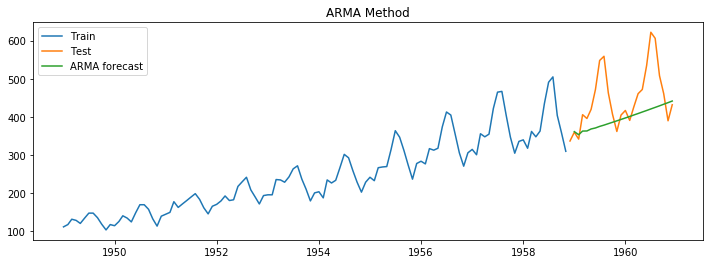

In [56]:
plt.figure(figsize=(12,4))
plt.plot( data['Passengers'][:train_len-1], label='Train')
plt.plot(data['Passengers'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculate RMSE and MAPE

In [57]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arma['arma_forecast'][train_len-1:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.10,6.53
0,Holt Winters' multiplicative method,34.83,6.91
0,Autoregressive (AR) method,93.39,13.77
0,Moving Average (MA) method,91.21,13.39
0,Autoregressive moving average (ARMA) method,88.88,12.89


## Auto regressive integrated moving average (ARIMA)

In [58]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.009624
ar.L1.D.y   -0.527115
ma.L1.D.y    0.798281
dtype: float64


C:\Users\25003850\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\25003850\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Recover original time series forecast

In [59]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

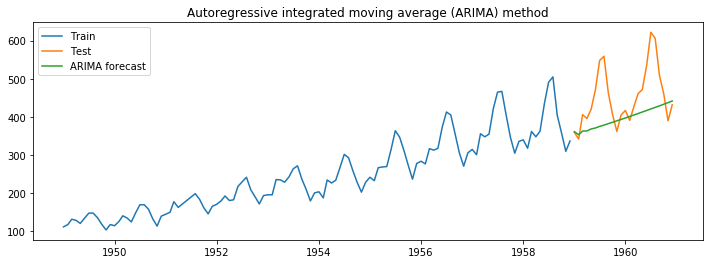

In [60]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [61]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arima['arima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.10,6.53
0,Holt Winters' multiplicative method,34.83,6.91
0,Autoregressive (AR) method,93.39,13.77
0,Moving Average (MA) method,91.21,13.39
0,Autoregressive moving average (ARMA) method,88.88,12.89


## Seasonal auto regressive integrated moving average (SARIMA)

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\25003850\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ar.L1       0.388460
ma.L1      -0.678612
ar.S.L12   -0.043682
ma.S.L12   -0.516362
sigma2      0.001405
dtype: float64


### Recover original time series forecast

In [63]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

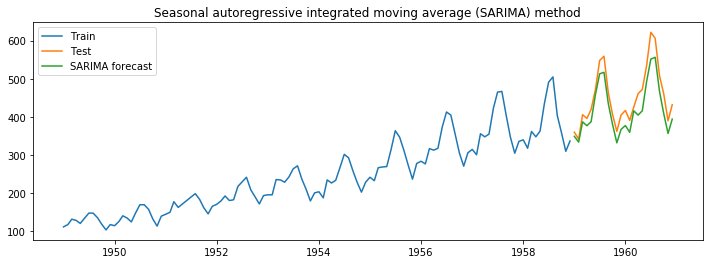

In [64]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [65]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.10,6.53
0,Holt Winters' multiplicative method,34.83,6.91
0,Autoregressive (AR) method,93.39,13.77
0,Moving Average (MA) method,91.21,13.39
0,Autoregressive moving average (ARMA) method,88.88,12.89


## Seasonal auto regressive integrate moving average with exogenous variable (SARIMAX)

### Import promotion data

In [66]:
promo = pd.read_csv('promotion.csv', header = None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
...,...
1960-08-01,1
1960-09-01,1
1960-10-01,1


### Split promotion data into train and test data sets

In [67]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

### Build SARIMAX model

In [68]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=promo_train) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\25003850\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Event       0.034345
ar.L1       0.479401
ma.L1      -0.741823
ar.S.L12   -0.063911
ma.S.L12   -0.558235
sigma2      0.001335
dtype: float64


### Recover original time series forecast

In [69]:
y_hat_sarimax = data_boxcox_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max(), exog=promo_test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

### Plot train, test and forecast

In [2]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX method')
plt.show()

NameError: name 'plt' is not defined

### Calculate RMSE and MAPE

In [71]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarimax['sarimax_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarimax['sarimax_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.10,6.53
0,Holt Winters' multiplicative method,34.83,6.91
0,Autoregressive (AR) method,93.39,13.77
0,Moving Average (MA) method,91.21,13.39
0,Autoregressive moving average (ARMA) method,88.88,12.89
